In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from inverse_utils import sampling_mask_gen, ifft, nrmse_np, fft
from skimage.metrics import structural_similarity as ssim
from inverse_diffusion import DCTGaussianBlur

In [5]:
def nrmse(x,y):
    num = torch.norm(x-y)
    den = torch.norm(x)
    return num/den

In [9]:
samp_num = 0
sz = 256
R = 3
gamma = 10.0
file = f'/home/blevac/infty-diff/results/sample_num{samp_num}_img_size{sz}_R{R}_gamma{gamma}.pt'
cont = torch.load(file)
print(cont.keys())

gt_img = cont['gt_img']
recon_img = cont['img_out']
deblurred_recon_img = cont['deblurred_img_out']
kspace = torch.tensor(cont['kspace'])
# img_stack = cont['img_stack']
ZF_recon = ifft(kspace).numpy()
mask = cont['mask'].cpu()
print(ZF_recon.shape)
print(gt_img.shape)
print(recon_img.shape)
# print(img_stack.shape)

# recon_img=img_stack[-2][None].numpy()

dict_keys(['gt_img', 'deblurred_img_out', 'inverse_deblurred_img_out', 'img_out', 'kspace', 'mask'])
(1, 1, 256, 256)
(1, 1, 256, 256)
(1, 1, 256, 256)


In [11]:
img_size = 256
std = 1
mollifier = DCTGaussianBlur(img_size, std=std)


In [12]:
# gt image to 2 channels
gt_img_torch_2ch = torch.view_as_real(torch.tensor(gt_img[:,0,...])).permute(0,-1,-3,-2)
print(gt_img_torch_2ch.shape)

torch.Size([1, 2, 256, 256])


In [13]:
mollified_2ch = mollifier(gt_img_torch_2ch.to(torch.float32))
mollified = mollified_2ch[:,0,...] + 1j*mollified_2ch[:,1,...]
deblurred_img_2ch = mollifier.undo_wiener(mollified_2ch)
deblurred_img_2ch = mollifier.inverse(mollified_2ch)
deblurred_gt_img_2ch = mollifier.undo_wiener(gt_img_torch_2ch.to(torch.float32))
deblurred_gt_img = deblurred_gt_img_2ch[:,0,...] + 1j*deblurred_gt_img_2ch[:,1,...]
deblurred_img = deblurred_img_2ch[:,0,...] + 1j*deblurred_img_2ch[:,1,...]

print(mollified_2ch.shape)

torch.Size([1, 2, 256, 256])


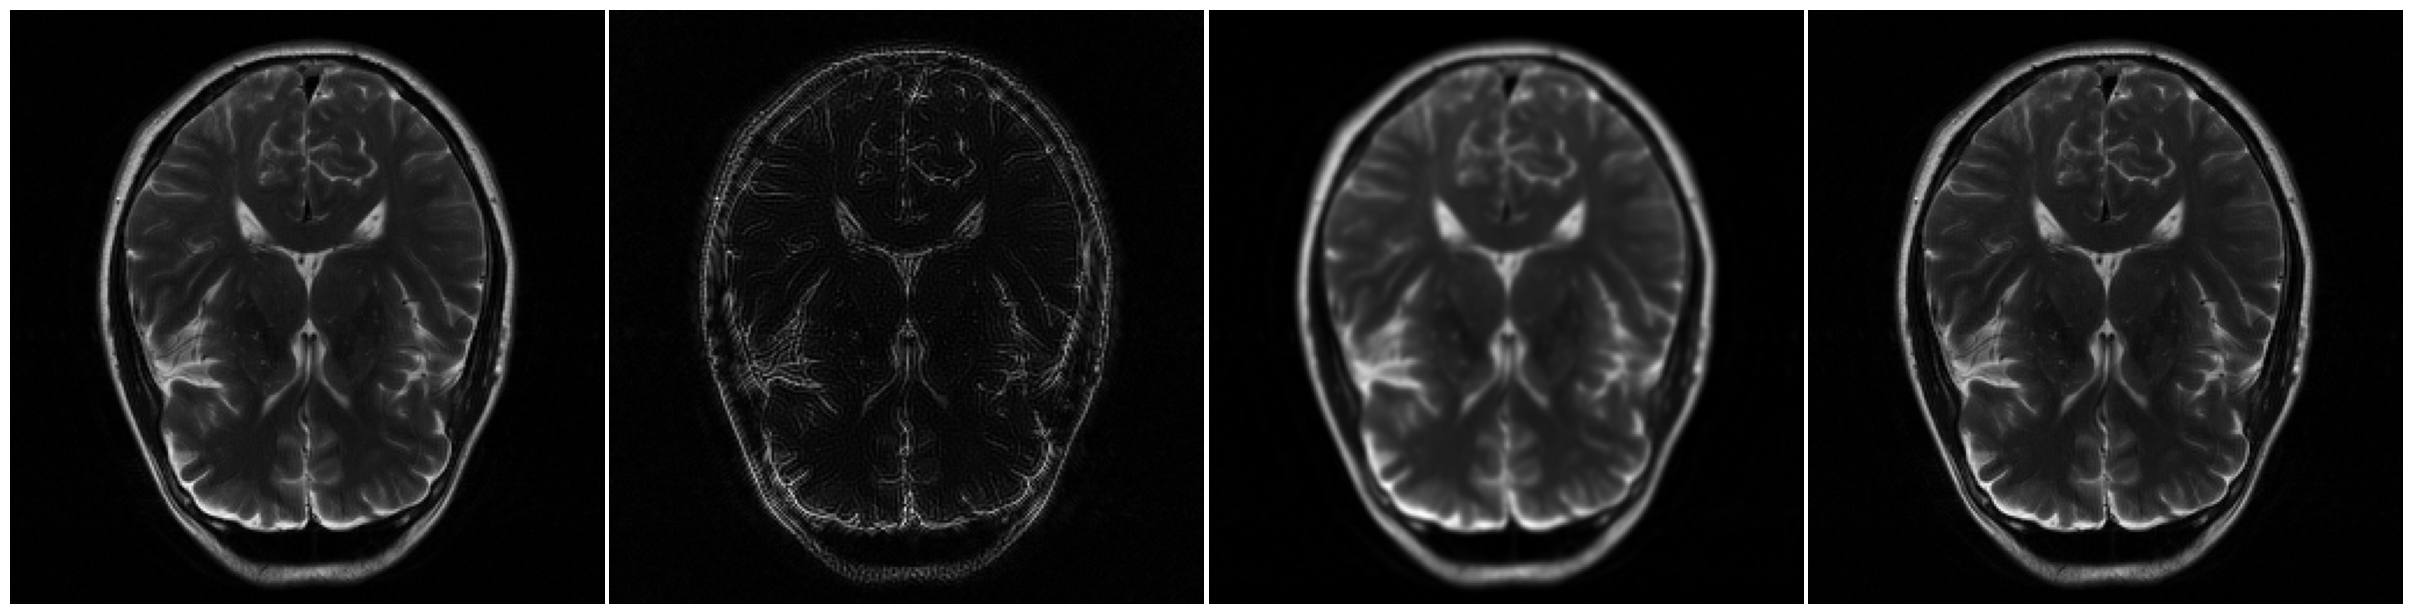

In [14]:
plt.figure(figsize=(24,6))

plt.subplot(1,4,1)
plt.imshow(abs(gt_img[0,0,...]),cmap='gray')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(abs(deblurred_gt_img[0,...]),cmap='gray')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(abs(mollified[0,...]),cmap='gray')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(abs(deblurred_img[0,...]),cmap='gray')
plt.axis('off')


plt.tight_layout(pad=0.2)

In [15]:
print(nrmse(abs(torch.tensor(gt_img[0,0,...])),abs(mollified[0,...])))
print(nrmse(abs(torch.tensor(gt_img[0,0,...])),abs(deblurred_img[0,...])))


tensor(0.1964, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)


In [16]:
forward_filter = mollifier.gaussian
reverse_filter = mollifier.gaussian_conj / (mollifier.gaussian * mollifier.gaussian_conj + mollifier.inv_snr**2)

torch.Size([256, 256])


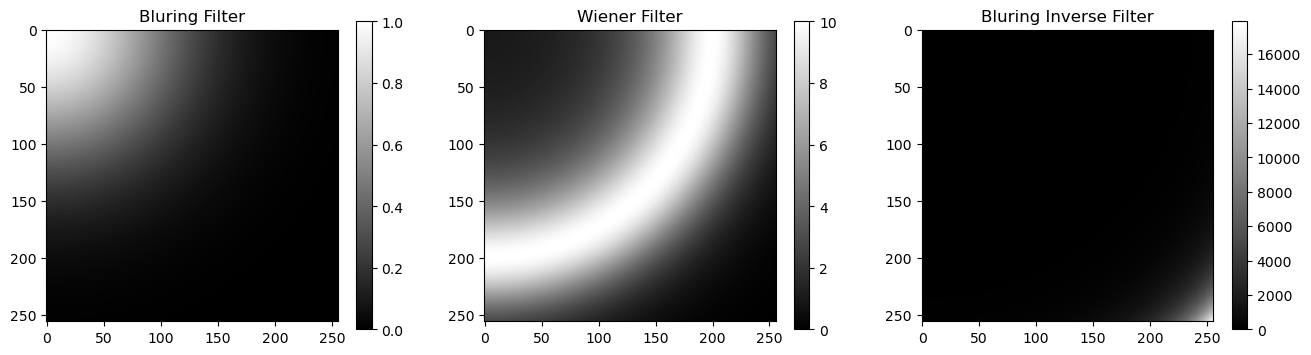

In [17]:
print(mollifier.gaussian.shape)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title('Bluring Filter')
plt.imshow(abs(forward_filter),cmap='gray',vmin = 0)
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Wiener Filter')
plt.imshow(abs(reverse_filter),cmap='gray', vmin = 0)
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Bluring Inverse Filter')
plt.imshow(abs(1/(forward_filter)),cmap='gray', vmin = 0)
plt.colorbar()


## kspace effects off mollification

/tmp/ipykernel_2520879/3911072277.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ZF_2ch = torch.view_as_real(torch.tensor(ZF_recon[:,0,...])).permute(0,-1,-3,-2)


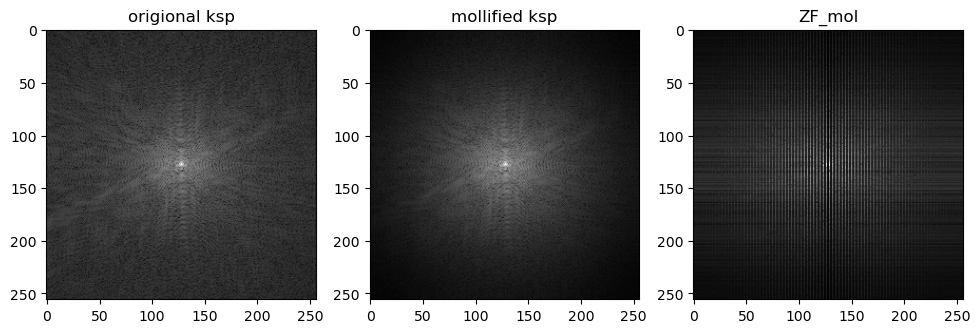

In [31]:
fs_ksp = fft(torch.tensor(gt_img))
fs_mol_ksp = fft(mollified)


ZF_recon = ifft(kspace)
ZF_2ch = torch.view_as_real(torch.tensor(ZF_recon[:,0,...])).permute(0,-1,-3,-2)
ZF_mol_2ch = mollifier(ZF_2ch.to(torch.float32))
ZF_mol = ZF_mol_2ch[:,0,...] + 1j*ZF_mol_2ch[:,1,...]
ZF_mol_ksp = fft(ZF_mol)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.title('origional ksp')
plt.imshow(abs(fs_ksp[0,0])**.2,cmap = 'gray')
plt.subplot(1,4,2)
plt.title('mollified ksp')
plt.imshow(abs(fs_mol_ksp[0])**.2,cmap = 'gray')
plt.subplot(1,4,3)
plt.title('scaling')
plt.imshow(abs(fs_mol_ksp[0]/fs_ksp[0,0])**.2,cmap = 'gray')
plt.subplot(1,4,3)
plt.title('ZF_mol')
plt.imshow(abs(ZF_mol_ksp[0])**.2,cmap = 'gray')

In [39]:
x = 135
y = 128

print('FS Mol Ksp: ', fs_mol_ksp[0,y,x])
print('ZF Mol Ksp: ', ZF_mol_ksp[0,y,x])

FS Mol Ksp:  tensor(-0.0749-0.1214j)
ZF Mol Ksp:  tensor(-0.0749-0.1212j)
